<a href="https://colab.research.google.com/github/mlc-ai/notebooks/blob/main/9_Computational_Graph_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ep9: Computational Graph Optimization

## Install packages 

For this course, we will use some ongoing development in tvm, which is an open-source machine learning compilation framework. We provide the following command to install a packaged version for mlc course. 

In [70]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels


## Prelude




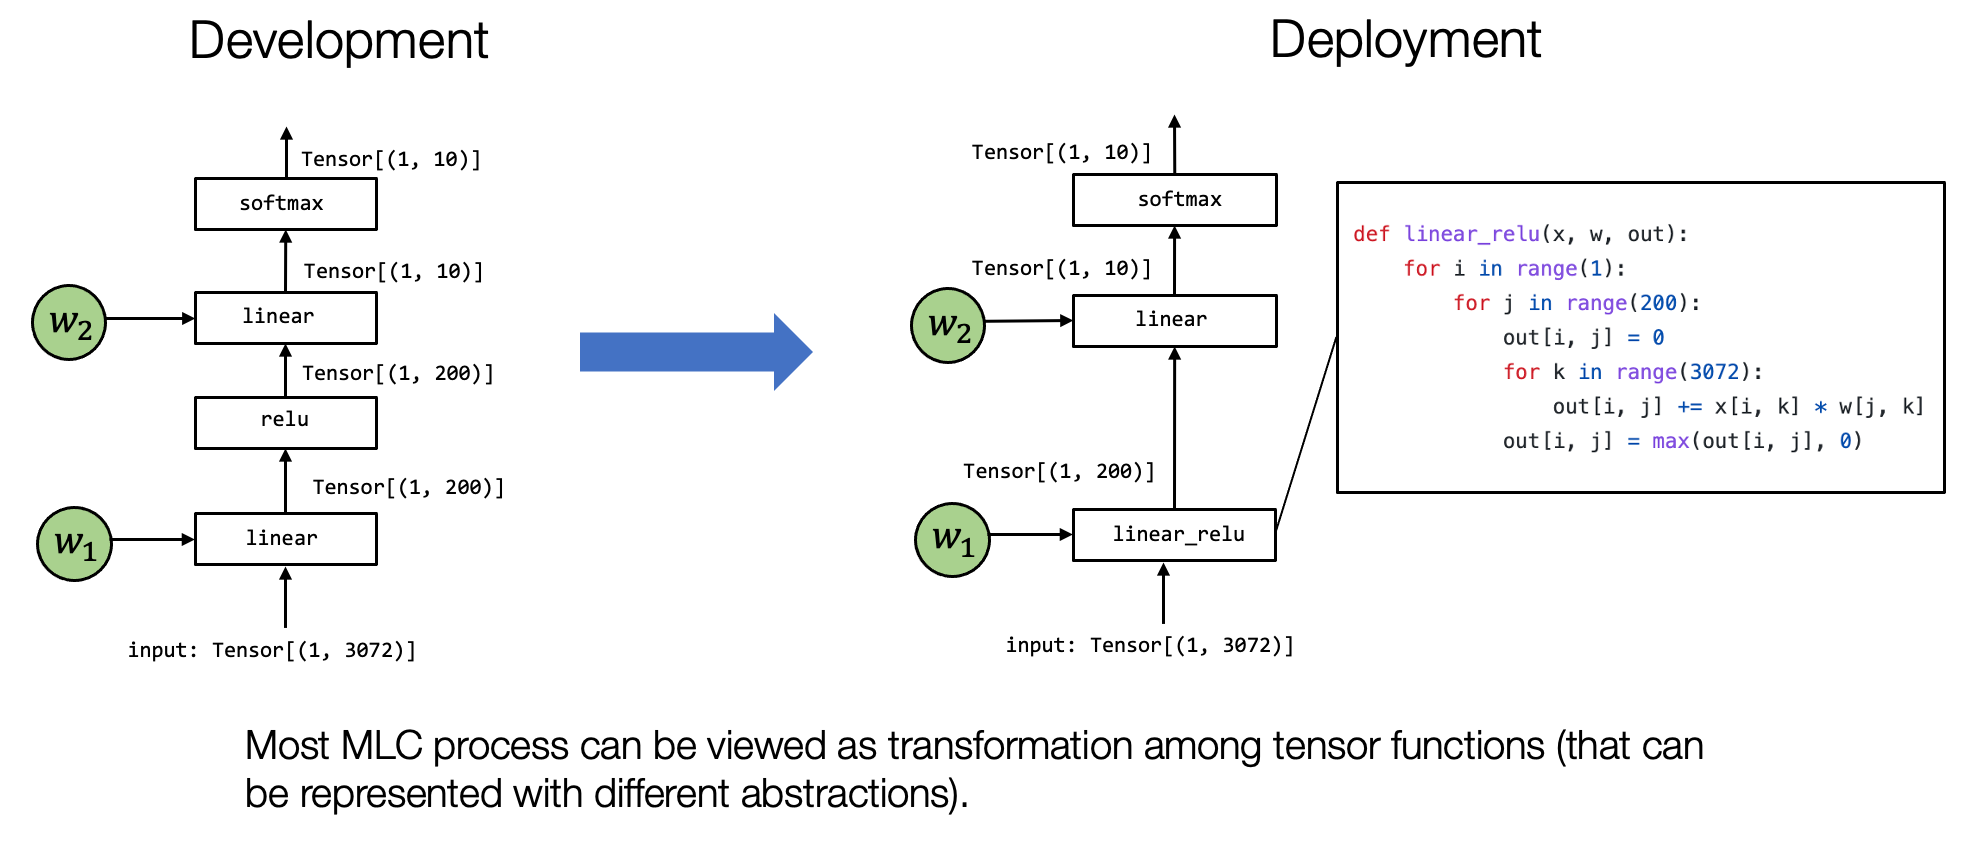


Most of the MLC process can be viewed as transformation among tensor functions. In the past chapters, we studied how to transform each primitive tensor functions individually. In this chapter, let us talk about high-level transformations among computational graphs.



## Preparations

To begin with, let us import the necessary dependencies.


In [71]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
from tvm import relax, topi
import numpy as np

## Pattern Match and Rewriting



To begin with, let us start with the following example.

In [72]:
@tvm.script.ir_module
class MyModule:
    @R.function
    def main(x: Tensor((3, 4), "float32"), y: Tensor((3, 4), "float32")):
        with relax.dataflow():
            lv0 = relax.multiply(x, y)
            gv0 = relax.add(lv0, y)
            relax.output(gv0)
        return gv0

`MyModule` contains a relax function with two high-level operators, relax.multiply and relax.add. Our goal is to find these two operators and replace it
with a call into `relax.ewise_fma` operator.

Before we dive into how to do that exactly, let us first examine the data structure that makes up the MyModule. Each IRModule contains a collection of functions, and the function body is composed of a set of data structures called abstract syntax trees (AST).

In [73]:
relax_func = MyModule["main"]

Each function is represented by a relax.Function node

In [74]:
type(relax_func)

tvm.relax.expr.Function

The function contains a list of parameters

In [75]:
relax_func.params

[relax.expr.Var(0xa8f2d80), relax.expr.Var(0xa750480)]

The function contains a body fields that represents its return value and set of binding blocks in the function.

In [76]:
func_body = relax_func.body
type(func_body)

tvm.relax.expr.SeqExpr

The function body SeqExpr contains a sequence of (binding) blocks

In [77]:
func_body.blocks

[relax.expr.DataflowBlock(0x3444520)]

In [78]:
dataflow_block = func_body.blocks[0]

In our particular case, we have a single data flow block that contains
two bindings. Each binding corresponds to one of the following two lines

```python
lv0 = relax.multiply(x, y)
gv0 = relax.add(lv0, y)
```

In [ ]:
dataflow_block.bindings

In [ ]:
binding = dataflow_block.bindings[0]

Each binding have a var field that corresponds to the left hand side of the binding (lv0, gv0)

In [79]:
binding.var

relax.expr.DataflowVar(0x6c36300)

And its value field corresponds to the right-hand side of the binding. Each value field corresponds to a `relax.Call` node representing a call into a primitive function

In [80]:
binding.value

CallNode(Op(relax.multiply), [relax.expr.Var(0x3463080), relax.expr.Var(0x3463300)], (nullptr), [])

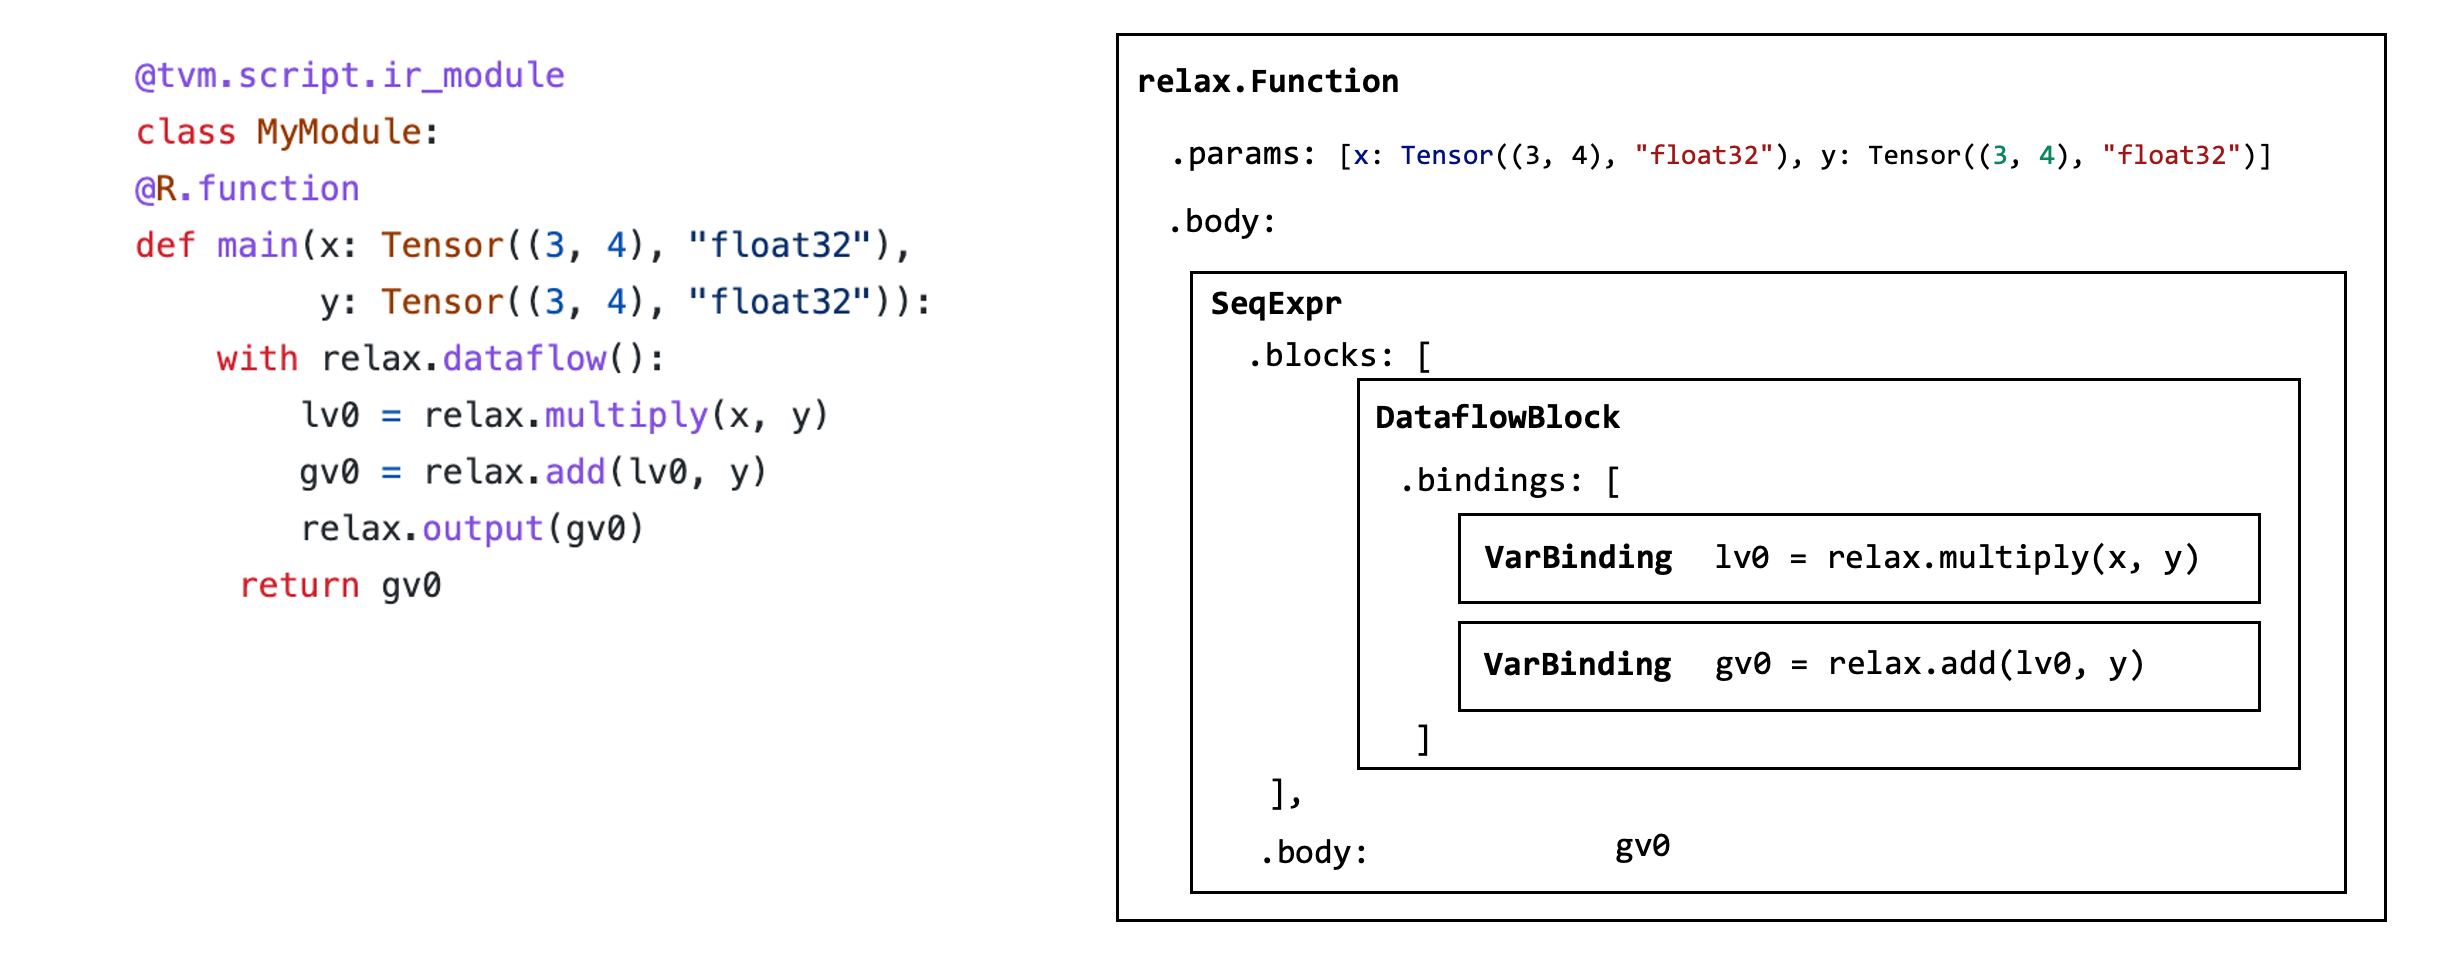

The above figure summarizes the data structure involved in this particular function.

One approach to rewrite the program would be to traverse MyModule's AST recursively and generate a transformed AST. We can certainly do that using the python API available. However, we can use extra tooling support to simplify the process. The following code block follows a design pattern called **visitor pattern** that allows us to visit each AST node and rewrite them to transformed versions.

In [81]:
@relax.expr_functor.mutator
class EwiseFMARewriter(relax.PyExprMutator):
    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)
        add_op = tvm.ir.Op.get("relax.add")
        multiply_op = tvm.ir.Op.get("relax.multiply")
        ewise_fma_op = tvm.ir.Op.get("relax.ewise_fma")

        if call.op != add_op:
            return call

        value = self.lookup_binding(call.args[0])
        if not isinstance(value, relax.Call) or value.op != multiply_op:
            return call
        
        fma_call = relax.Call(
            ewise_fma_op, [value.args[0], value.args[1], call.args[1]], None, None
        )
        return fma_call


updated_fn = EwiseFMARewriter().visit_expr(MyModule["main"])
updated_fn.show()

We can go ahead and run the code. Note that the result rewrites gv0 to the fused operator but leaves lv0 in the code. We can use `remove_all_unused` to further simplify the code block.

In [82]:
relax.analysis.remove_all_unused(updated_fn).show()

## Fuse Linear and ReLU

Now we have get a basic taste of graph rewriting. Let us try it on an end to end model. 

In [83]:
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

File ‘fasionmnist_mlp_params.pkl’ already there; not retrieving.



In [84]:
import pickle as pkl
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

The following code reconstructs the FashionMNIST MLP model we used in our past chapters. To simplify our explaination, we directly construct the model using high-level operators such as `relax.op.add` and `relax.op.dense`.

In [85]:
def create_model():
    bb = relax.BlockBuilder()
    x = relax.Var("x", (1, 784), relax.DynTensorType(2, "float32"))
    w0 = relax.const(mlp_params["w0"], "float32")
    b0 = relax.const(mlp_params["b0"], "float32")
    w1 = relax.const(mlp_params["w1"], "float32")
    b1 = relax.const(mlp_params["b1"], "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit(relax.op.dense(x, w0))
            lv1 = bb.emit(relax.op.add(lv0, b0))
            lv2 = bb.emit(relax.op.relu(lv1))
            lv3 = bb.emit(relax.op.dense(lv2, w1))
            lv4 = bb.emit(relax.op.add(lv3, b1))
            gv = bb.emit_output(lv4)
        bb.emit_func_output(gv)

    return bb.get()

In [86]:
MLPModel = create_model()

MLPModel.show()

We aim to "fuse" the dense and add operations into a single group. The following code achieves that through the following steps:

- Identify `dense` and `add` patterns.
- Generate another fused sub-function that calls into the dense and add operators.
- Replace `dense` and `add` with the fused sub-functions.

In [87]:
@relax.expr_functor.mutator
class DenseAddFusor(relax.PyExprMutator):
    def __init__(self, mod: IRModule) -> None:
        super().__init__()
        self.mod_ = mod
        # cache pre-defined ops
        self.add_op = tvm.ir.Op.get("relax.add")
        self.dense_op = tvm.ir.Op.get("relax.nn.dense")
        self.counter = 0

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            # avoid already fused primitive functions
            if "Primitive" in func.attrs.keys() and func.attrs["Primitive"] != 0:
                continue
            updated_func = self.visit_expr(func)
            updated_func = relax.analysis.remove_all_unused(updated_func)
            self.builder_.update_func(global_var, updated_func)
        
        return self.builder_.get()

    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        def match_call(node, op):
            if not isinstance(node, relax.Call):
                return False
            return node.op == op
          
        # pattern match dense => add
        if not match_call(call, self.add_op):
            return call

        value = self.lookup_binding(call.args[0])
        if value is None:
            return call

        if not match_call(value, self.dense_op):
            return call

        x = value.args[0]
        w = value.args[1]
        b = call.args[1]

        # construct a new fused primitive function
        param_x = relax.Var("x", x.shape_, x._checked_type_)
        param_w = relax.Var("w", w.shape_, w._checked_type_)
        param_b = relax.Var("b", b.shape_, b._checked_type_)

        bb = relax.BlockBuilder()

        fn_name = "fused_dense_add%d" % (self.counter)
        self.counter += 1
        with bb.function(fn_name, [param_x, param_w, param_b]):
            with bb.dataflow():
                lv0 = bb.emit(relax.op.nn.dense(param_x, param_w))
                gv = bb.emit_output(relax.op.add(lv0, param_b))
            bb.emit_func_output(gv)

        # Add Primitive attribute to the fused funtions
        fused_fn = bb.get()[fn_name].with_attr("Primitive", 1)
        global_var = self.builder_.add_func(fused_fn, fn_name)

        # construct call into the fused function
        return relax.Call(global_var, [x, w, b], None, None)

@tvm.ir.transform.module_pass(opt_level=2, name="DeseAddFuse")
class FuseDenseAddPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return DenseAddFusor(mod).transform()


MLPFused = FuseDenseAddPass()(MLPModel)
MLPFused.show()

### Why Creating a Sub-function

In the above example, we created two sub-functions with the prefix `fuse_dense_add`. These sub-function bodies contain information about the operations performed by the fused operator. An alternative to this rewriting is simply creating a separate primitive operation for the fused operator (like `ewise_fma`). However, as we are looking into fusing more operators, there can be an exponential amount of possible combinations. A sub-function that groups the fused operation together provides the same amount of information for follow-up code lowering without introducing a dedicated high-level operator for each fusion pattern.

## Map to TensorIR Calls

The fused IRModule only contains calls into high-level operations. To further low-level optimization and code generation, we need to translate those high-level primitive operators into corresponding TensorIR functions (or environment library functions).

The following code  remaps high-level operations to the corresponding TensorIR functions. Here we leverage the internal block builder in each Mutator and return the transformed value using `call_te`.

In [89]:
@relax.expr_functor.mutator
class LowerToTensorIR(relax.PyExprMutator):
    def __init__(self, mod: IRModule, op_map) -> None:
        super().__init__()
        self.mod_ = mod
        self.op_map = {
            tvm.ir.Op.get(k): v for k, v in op_map.items()
        }


    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        if call.op in self.op_map:
            return self.op_map[call.op](self.builder_, call)
        return call

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            updated_func = self.visit_expr(func)
            self.builder_.update_func(global_var, updated_func)
        
        return self.builder_.get()


def map_dense(bb, call):
    x, w = call.args
    return bb.call_te(topi.nn.dense, x, w)

def map_add(bb, call):
    a, b = call.args
    return bb.call_te(topi.add, a, b)

def map_relu(bb, call):
    return bb.call_te(topi.nn.relu, call.args[0])


op_map = {
  "relax.nn.dense": map_dense,
  "relax.add": map_add,
  "relax.nn.relu": map_relu
}

@tvm.ir.transform.module_pass(opt_level=0, name="LowerToTensorIR")
class LowerToTensorIRPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return LowerToTensorIR(mod, op_map).transform()


MLPModelTIR = LowerToTensorIRPass()(MLPFused)
MLPModelTIR.show()

Note that in the above code. `fused_dense_add0` and `fused_dense_add1` still are high-level relax functions that calls into the corresponding TensorIR dense and add functions. We can turn them into a single TensorIR function, which then can be used for follow-up optimization and code generation phases.

In [90]:
MLPModelFinal = relax.transform.FuseTIR()(MLPModelTIR)
MLPModelFinal.show()

## Build and Run

We can go ahead and build the final module and try it out on an example picture.

In [91]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

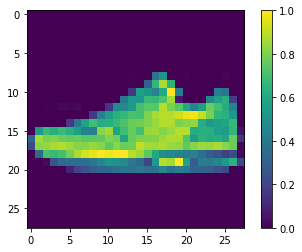

Class: Sneaker


In [92]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [93]:
ex = relax.vm.build(MLPModelFinal, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Sneaker


## Discussions

This section comes back to our common theme of **transformation** among computational graphs. Despite being minimum, this sequence of transformations covers two important optimizations we commonly do in MLC process -- fusion and loop level code lowering.

Real-world MLC process can contain more powerful and robust transformations. For example, our fusion pass can create duplicated dense computations in which a dense operator is referenced in two follow-ups add operations. A robust fusion pass will detect that and choose to skip such cases. Additionally, we do not want to have to write down rules for each combination. Instead, TVM's internal fusor will analyze the TensorIR function loop patterns and use them in fusion decisions.

Notably, each of these transformations is composable with each other. For example, we can choose to use our version of customized fusor to support additional new fusion patterns that we want to explore and then feed into an existing fusor to handle the rest of the steps.


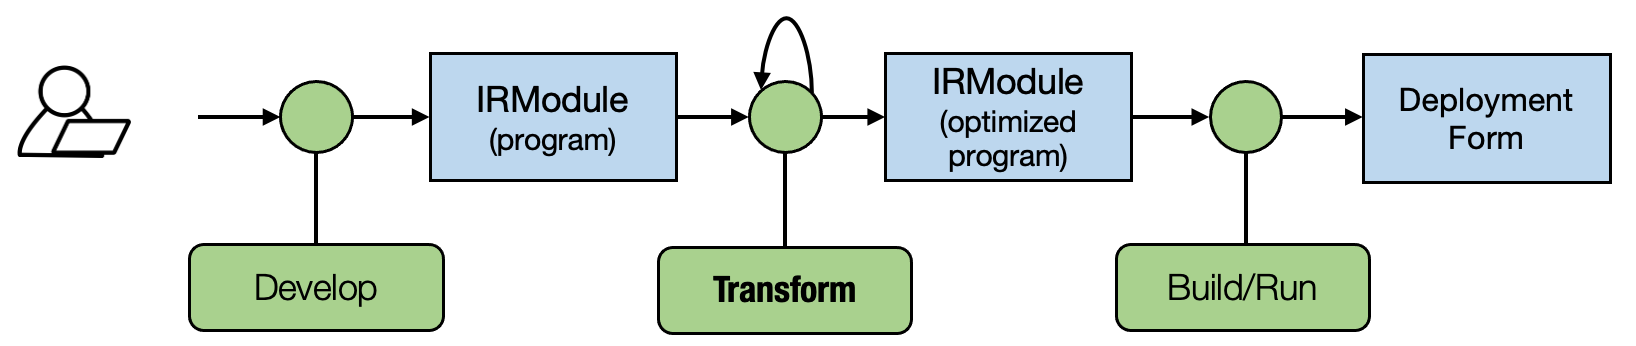

## Summary

- We can optimize tensor programs by rewriting computational graph data structures.
- Visitor pattern to rewrite call nodes.
- We can perform computational graph transformations, such as fusion and loop-level program lowering.
